In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import dabest
import pathlib as plb
from scipy.stats import norm
import statistics

### Reading in and cleaning up the data

In [4]:
### Read in data that contains unblinded compounds, chemotaxis indices and worm totals
### for the March 2021 screen.

screen_data = pd.read_csv('C:/Users/Emily/Documents/_2021_03_screen/2103_ia_results_unblinded.csv', index_col=0)

screen_data.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Plate ID,Slot,Well,Compound Name
0,1A,135,0.706422,1,NaN,NPP_210319_POST_003,NPP_210319_007,1,A,Alyssin
1,1A,181,0.607843,1,NaN,NPP_210322_POST_005,NPP_210322_017,1,A,Alyssin
2,1A,226,0.757576,1,NaN,NPP_210325_POST_004,NPP_210325_013,1,A,Alyssin
3,1B,96,0.409836,2,NaN,NPP_210319_POST_003,NPP_210319_007,1,B,Furfural
4,1B,227,0.395833,2,NaN,NPP_210322_POST_005,NPP_210322_017,1,B,Furfural


In [5]:
#Creating a subset of the 03/2021 data that contains only values for DMSO:DMSO
subset =  screen_data.loc[screen_data['Compound Name']== 'DMSO']

#Generating a file path to dynamically read in worm location files
wrm_locs_fldr = plb.Path('C:/Users/Emily/Documents/_2021_03_screen/_2021_03_automated_results/')

In [7]:
# A function that will aggregate the all worm locations for a given condition

def get_worm_locs(row, wrms, result_dict): 

    fname = row['File Name']
    wellnum = row['WellNo']
    loc_fname =  wrms.joinpath('loc_' + fname + '_' + wellnum + '.csv')
    temp = pd.read_csv(loc_fname)
    compound = row['Compound Name']
    xs = temp['centroid-1']
    #xs = list(temp['centroid-1'])
    if compound in result_dict:
        result_dict[compound] = result_dict[compound].append(xs)
        result_dict[compound].reset_index(inplace=True, drop=True)
        #result_dict[compound] = result_dict[compound]+xs
    else:
        result_dict[compound]=xs
    
    return result_dict


In [21]:
# Need to create an empty dictionary to hold the values
results_dict = {}
for index, row in subset.iterrows():
    pooled_refs = get_worm_locs(row, wrm_locs_fldr, results_dict)

#Casting dict to df. The algorithm will be resampling from 747 data points (worm locations) 
pooled_refs_df = pd.DataFrame.from_dict(pooled_refs)
print(len(pooled_refs_df))

747


### Bootstrapping steps
1. Randomly sample groups of 50, 100, 150 ... 300, 350 worms -> hold in an array
2. Calculate chemotaxis index for each group of worms
3. Iterate random sampling and CI calculation 100 times -> Hold CIs in an array
4. Plot

In [9]:
# Creating a np array of all worm locations from 2103 dataset to be used for resampling
x_dmso = np.asarray(pooled_refs_df['DMSO'])
# Generating sample pools of varying sizes
sample_sizes = [50, 100, 150, 200, 250, 300, 350]
# Resampling each sample size 100x
n = 100

In [10]:
# We need to generate a function to calculate the chemotaxis indices for each bootstrapped sample. The chemotaxis index
# will be used to assess where the variance for the model levels off

def calc_chemotaxis_index(worms):
    
    ## Assign features to zones of the plate
    left_area_boundary = int(4/9*3000) #Need to generate a more accurate boundary value
    #print(left_area_boundary)
    right_area_boundary = int(5/9*3000) #Need to generate a more accurate boundary value
    #print(right_area_boundary)

    left_side_worms = worms[worms['X'] <= left_area_boundary]
    #middle_w = worms[worms['centroid-1'] < right_area_boundary]
    #middle_worms = middle_w[middle_w['centroid-1'] >left_area_boundary]
    right_side_worms = worms[worms['X'] >= right_area_boundary]

    ## Calculate chemotaxis index
    worms_in_left_region = len(left_side_worms)
    #worms_in_middle_region = len(middle_worms)
    worms_in_right_region = len(right_side_worms)
    total_worms_found = len(right_side_worms) + len(left_side_worms)
    #print('Left; ' + str(worms_in_left_region) + '   Right: ' + str(worms_in_right_region))

    

    try:
        chemotaxis_index = ((worms_in_left_region - worms_in_right_region) 
                        / (worms_in_left_region + worms_in_right_region))
        return chemotaxis_index

    except ZeroDivisionError:
        return 0
    

### The following will generate a wide dataframe of the bootstrapped values
<p> The dfferent plotting approaches below require different dataframe formats (wide vs long). We create functions to generate both </p>

In [12]:
CI_df = pd.DataFrame(columns=sample_sizes)
for j in sample_sizes:
    CIs = []
    #for n in sample_sizes:
    i=0
    while i < 100:
        resample = np.random.choice(a=x_dmso, size=j, replace=True)
        resample_df = pd.DataFrame(resample, columns=['X'])
        CI = calc_chemotaxis_index(resample_df)
        CIs.append(CI)
        i += 1
    CI_df[j]= CIs
    #print(len(CIs))
CI_df.head()

,50,100,150,200,250,300,350
0,0.395349,0.108434,0.073529,0.101124,0.116071,0.119403,0.133758
1,0.162791,0.033708,-0.051852,0.147727,0.235023,0.196970,0.035599
2,0.066667,-0.098901,0.007634,0.275862,0.105263,0.086792,0.084416
3,-0.066667,0.142857,0.138686,-0.005650,0.062500,0.180451,0.068404
4,0.136364,0.149425,0.029851,0.038251,0.190698,0.157509,0.074919


### The following will generate a long dataframe

In [13]:
CI_df_long = pd.DataFrame(columns=['CI', 'N'])
for j in sample_sizes:
    CIs = []
    #for n in sample_sizes:
    i=0
    while i < 100:
        resample = np.random.choice(a=x_dmso, size=j, replace=True)
        resample_df_long = pd.DataFrame(resample, columns=['X'])
        CI = (calc_chemotaxis_index(resample_df_long), j)
        CIs.append(CI)
        i += 1
    CI_df_long = CI_df_long.append(pd.DataFrame(CIs, columns=['CI', 'N']))


In [15]:
v = CI_df_long.groupby('N').agg(np.var).reset_index()
CI_df_long['N'] = CI_df_long.N.astype(int)

In [14]:
#CI_df_long.to_csv('/Volumes/LaCie/_2021_03_screen/bootstrapped_CIs.csv')

### Fitting different models of the mean CI for each group. 
<p> We want to assess at what point the chemotaxis indices level off for each group. This will determine the grouping for minimum number of worms to be added to each well<p>

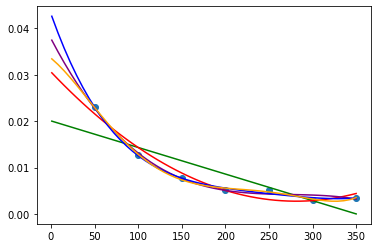

In [18]:
model1 = np.poly1d(np.polyfit(v.N , v.CI, 1))
model2 = np.poly1d(np.polyfit(v.N , v.CI, 2))
model3 = np.poly1d(np.polyfit(v.N , v.CI, 3))
model4 = np.poly1d(np.polyfit(v.N , v.CI, 4))
model5 = np.poly1d(np.polyfit(v.N , v.CI, 5))

polyline = np.linspace(1, 350, 50)
plt.scatter(v.N, v.CI)

#add fitted polynomial lines to scatterplot 
plt.plot(polyline, model1(polyline), color='green')
plt.plot(polyline, model2(polyline), color='red')
plt.plot(polyline, model3(polyline), color='purple')
plt.plot(polyline, model4(polyline), color='blue')
plt.plot(polyline, model5(polyline), color='orange')
plt.show()

### This is the first interation of the bootstrapping plot with an inset of the variance of chemotaxis index for each group

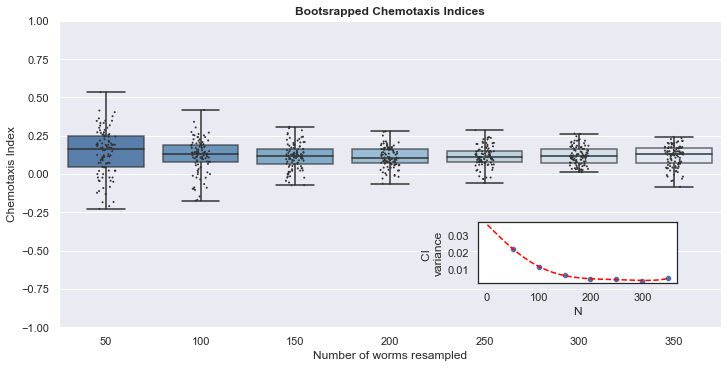

In [18]:

sns.set(style="darkgrid")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), constrained_layout=True)
axes = sns.boxplot(x="N", y="CI", data=CI_df_long, whis=np.inf,
                   palette="Blues_r", boxprops=dict(alpha=.7),ax=axes)
axes = sns.stripplot(x="N", y="CI", data=CI_df_long, size=2, color='.2', ax=axes)
axes.set(xlabel="Number of worms resampled", ylabel="Chemotaxis Index", ylim=(-1,1))
axes.set_title('Bootsrapped Chemotaxis Indices', weight='bold')

sns.set_style('white')
axins = inset_axes(axes,  "30%", "20%" ,loc="lower right", borderpad=4)
    
model5 = np.poly1d(np.polyfit(v.N, v.CI, 5))

#define scatterplot
polyline = np.linspace(1, 350, 50)
sns.scatterplot(x= v.N, y=v.CI, ax=axins)
axins.set(xlabel='N', ylabel='CI \nvariance')

#add fitted polynomial curve to scatterplot
plt.plot(polyline, model5(polyline), '--', color='red')

#plt.savefig('D:/NP_manuscript/figs/1D_bootstrap.png')

### This is the version of the figure that is currently being used in the manuscript. The variance is plotted above the boxplots for each group.

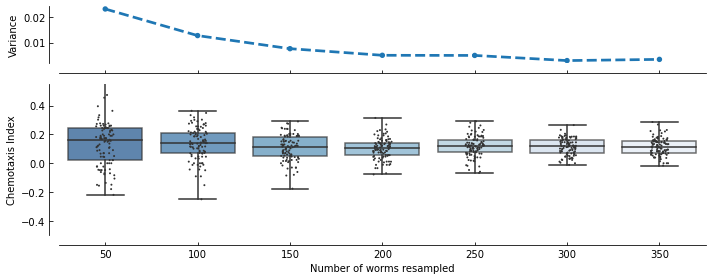

In [20]:
#sns.set(style="white")
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 4), sharex=True, gridspec_kw={'height_ratios': [.75, 2]})
model5 = np.poly1d(np.polyfit(v.N, v.CI, 5))

axes[0] = sns.pointplot(x='N', y='CI', data=v1, linestyle='--', ax=axes[0], markers='.')
axes[0].lines[0].set_linestyle("--")
axes[0].set(xlabel="", ylabel="Variance")
axes[0].tick_params(axis='both', tickdir='in')

axes[1] = sns.boxplot(x="N", y="CI", data=CI_df_long, whis=np.inf,
                   palette="Blues_r", boxprops=dict(alpha=.7), ax=axes[1])
axes[1] = sns.stripplot(x="N", y="CI", data=CI_df_long, size=2, color='.2', ax=axes[1])
axes[1].set(xlabel="Number of worms resampled", ylabel="Chemotaxis Index")
axes[1].tick_params(axis='both', tickdir='in')
axes[1].set_ylim(-.5,.55)

sns.despine(offset=10)
plt.rcParams['svg.fonttype'] = 'none'
fig.tight_layout()
#fig.savefig('D:/NP_manuscript/figs/stackd_bstrap.svg', dpi=300)